### Getting to know Dask: when data doesn't fit in Pandas anymore

### Getting to know Dask: when data doesn't fit in Pandas anymore


* Dask: Pandas-like parallel computing (http://dask.pydata.org)
* Disclaimer: this talk was concieved over beers, labeled 'A Good Idea...'
* Experiment: not really showing a solution, but a journey:   
learn from my mistakes
* I mostly work with Pandas, and 90% of my work is data wrangling of
untidy data
* 90% is in rather small data (<1 GB)
* What about larger, messy data (several csv 10 GB+)?




Let's begin with the Dask tutorial by Matthew Rocklin (https://github.com/dask/dask-tutorial)


<img src="images/pandas_logo.png" align="middle" width="30%">

### Dask DataFrame  

....

**Related Documentation**

*  [Dask DataFrame documentation](http://dask.pydata.org/en/latest/dataframe.html)
*  [Pandas documentation](http://pandas.pydata.org/)

**Main Take-aways**

1.  Dask.dataframe should be familiar to Pandas users
2.  The index grows to include partitions, which are important for efficient queries

### Setup

We create artifical data.

In [3]:
from prep import accounts_csvs
accounts_csvs(5, 1000000, 500)

import os
filename = os.path.join('data', 'accounts.*.csv')

### `dask.dataframe.read_csv`

This works just like `pandas.read_csv`, except on multiple csv files at once.

In [4]:
import dask.dataframe as dd
df = dd.read_csv(filename)
%time len(df)

Wall time: 3.91 s


15000000

In [5]:
df.head()

id    names  amount
0  492   Hannah  2419.0
1  489  Norbert   147.0
2  252    Sarah   724.0
3  272   George  8981.0
4   75   George    31.0

### Exercise: Inspect dask graph

Dask `DataFrame` copies a subset of the Pandas API.  

However unlike Pandas, operations on dask.dataframes don't trigger immediate computation, instead they add key-value pairs to an underlying dask graph.

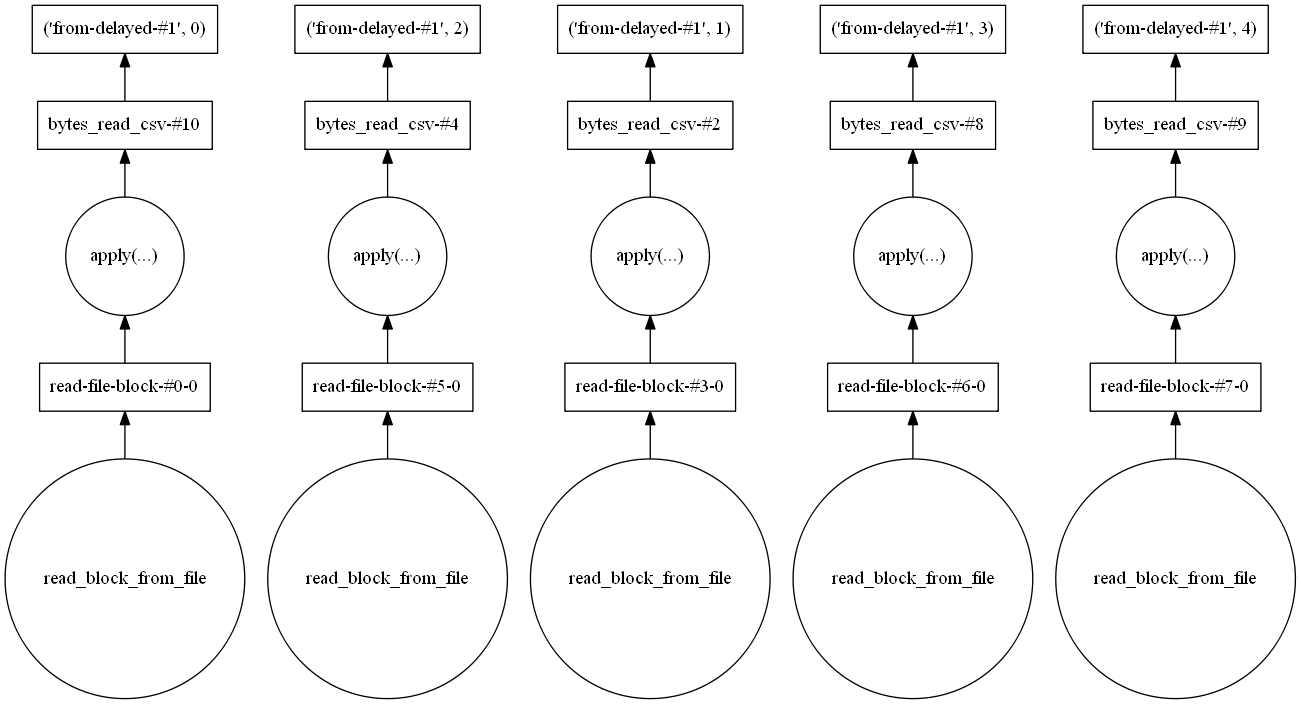

In [6]:
df._visualize()

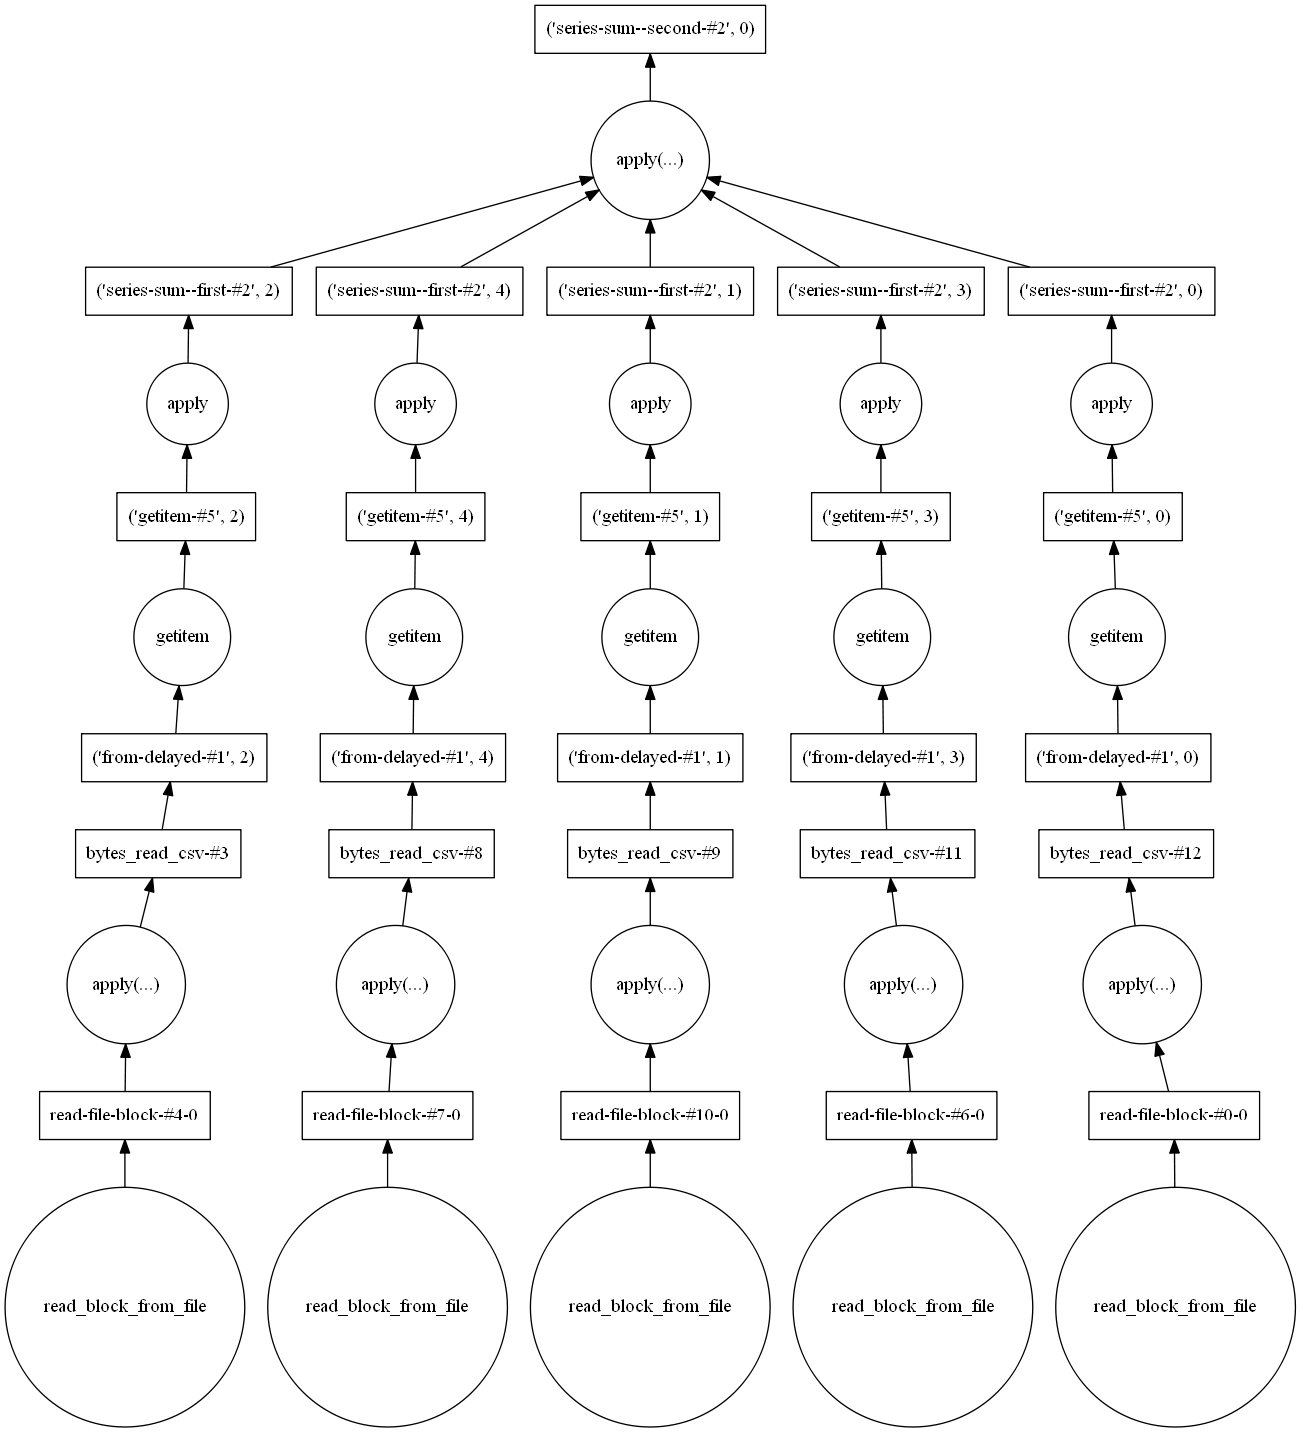

In [7]:
df.amount.sum()._visualize()

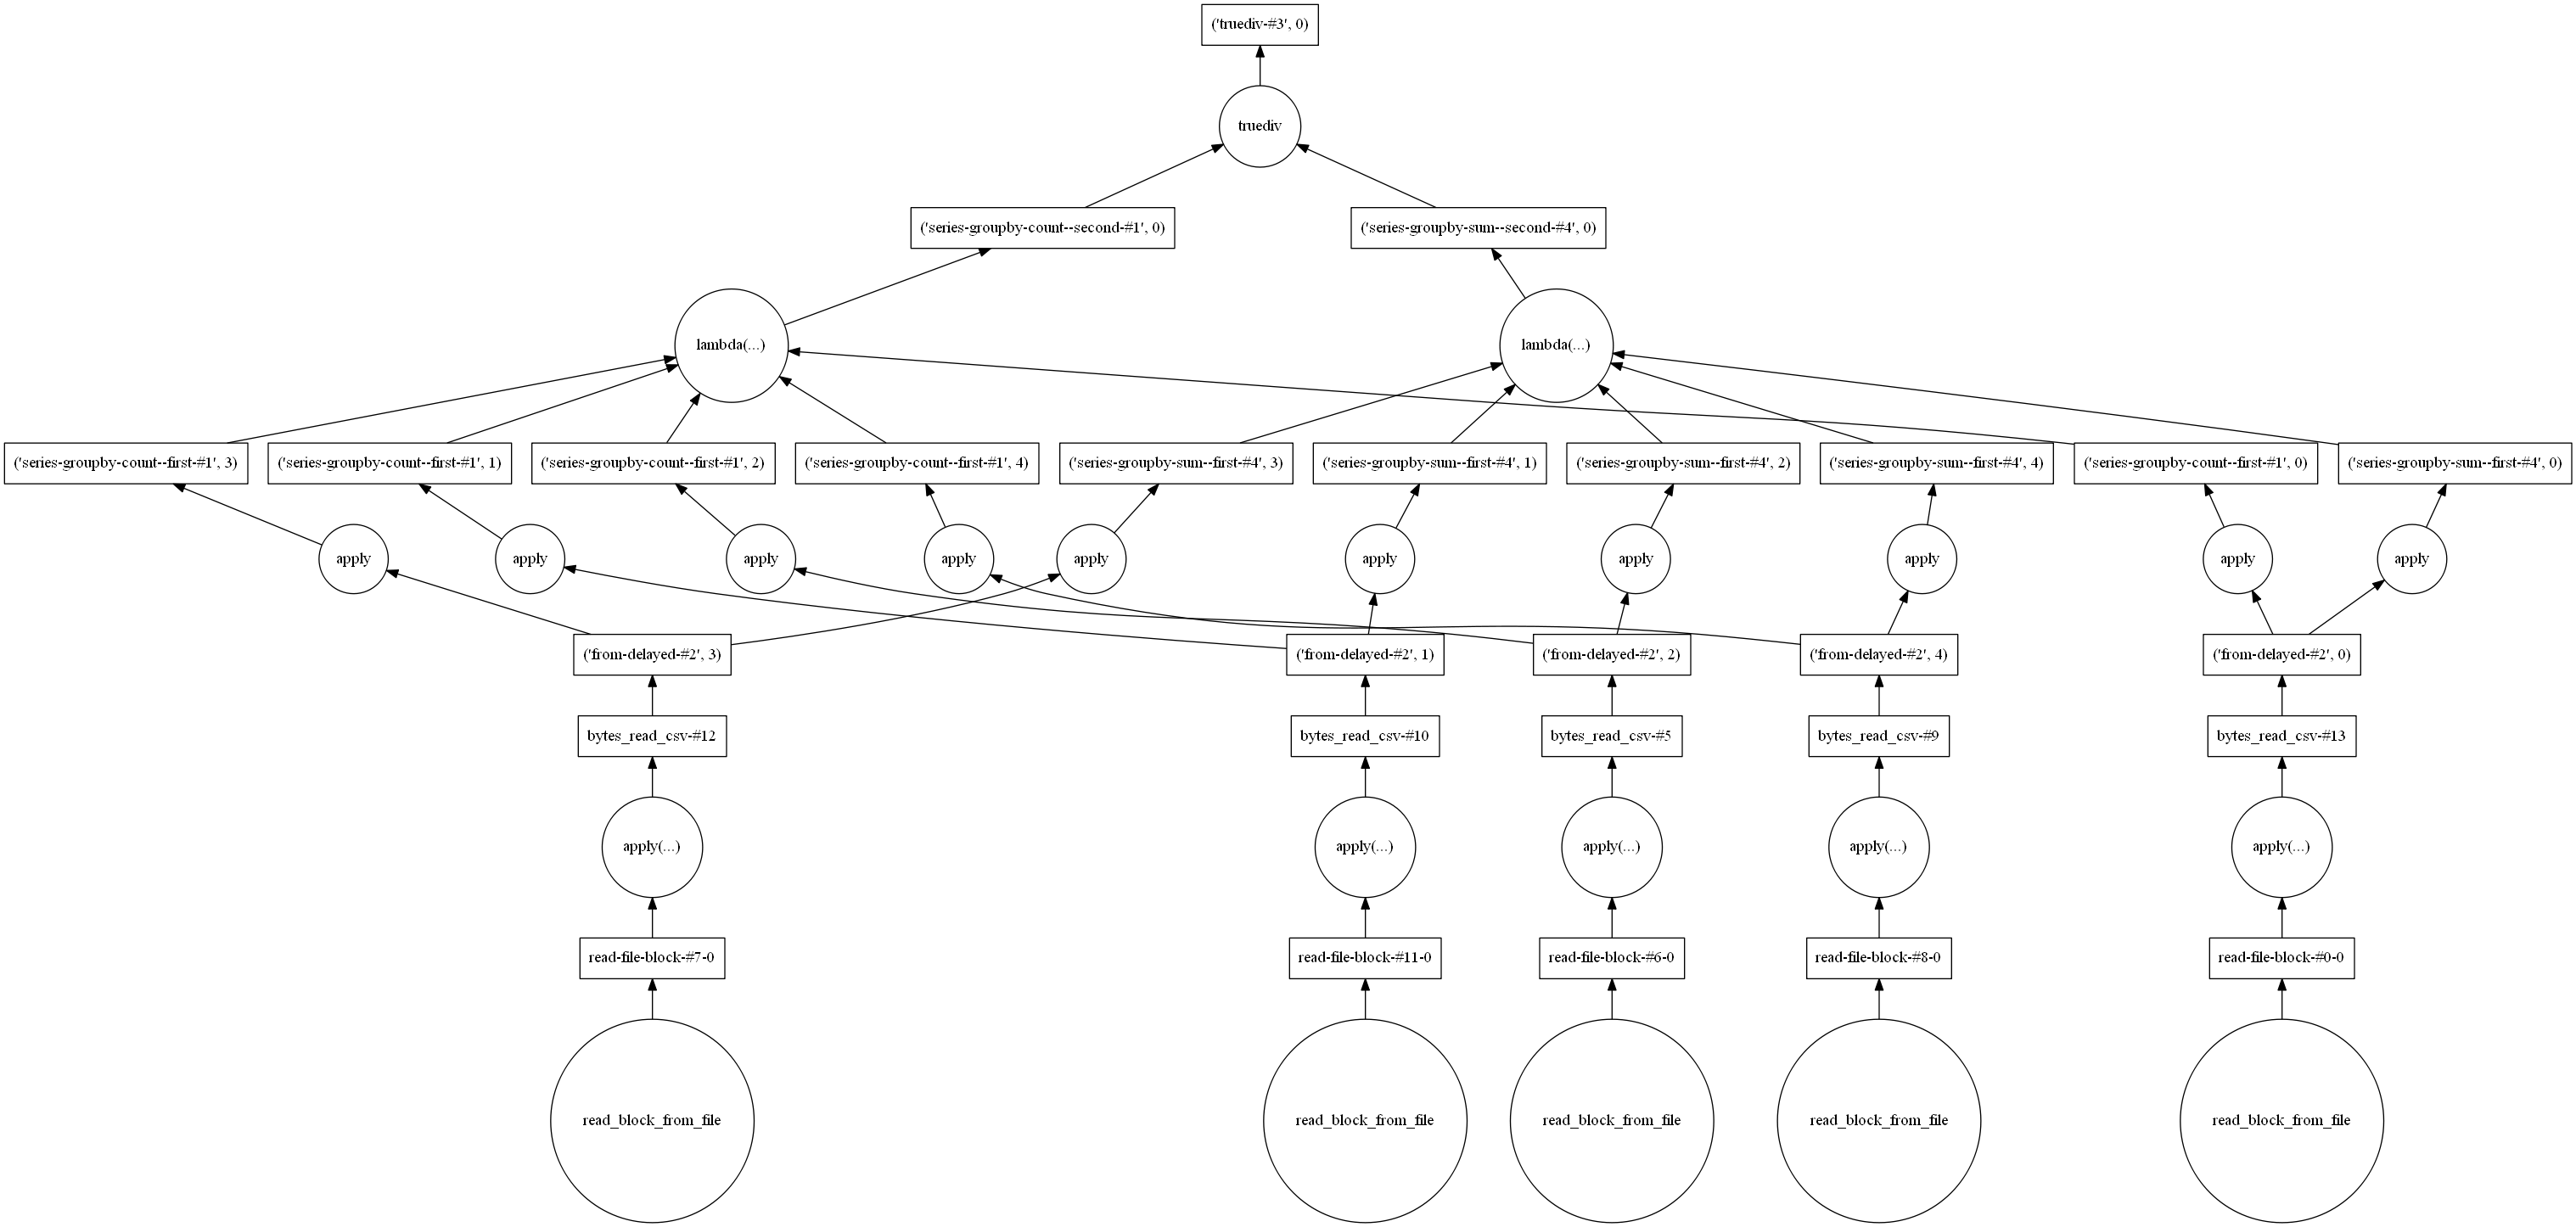

In [8]:
# Helpful advice: you can add filename=xy and so save the png
df.groupby(df.names).amount.mean()._visualize(filename='dask_groupby')

In [9]:
%time df.groupby(df.names).amount.mean().compute()

Wall time: 6.51 s


names
Alice       1057.176414
Bob         2005.139577
Charlie     1004.181560
Dan         1257.327212
Edith        714.753874
Frank        228.985557
George       736.673724
Hannah       819.359163
Ingrid      1113.190205
Jerry       1078.607358
Kevin        650.161457
Laura        700.648191
Michael      526.677872
Norbert      924.600543
Oliver       577.419973
Patricia     994.837257
Quinn        359.364182
Ray          967.130210
Sarah        797.257508
Tim         1870.289559
Ursula       919.901721
Victor       522.556647
Wendy       2599.815948
Xavier      1192.218389
Yvonne      1344.372801
Zelda        953.906258
Name: amount, dtype: float64

### How does this compare to Pandas?

#### Features and Size

Pandas is more mature and fully featured than `dask.dataframe`.  If your data fits in memory then you should use Pandas.  The `dask.dataframe` module gives you a limited `pandas` experience when you operate on datasets that don't fit comfortably in memory.

During this tutorial we provide a small dataset consisting of a few CSV files.  This dataset is 45MB on disk that expands to about 400MB in memory (the difference is caused by using `object` dtype for strings).  This dataset is small enough that you would normally use Pandas.

We've chosen this size so that exercises finish quickly.  Dask.dataframe only really becomes meaningful for problems significantly larger than this, when Pandas breaks with the dreaded 

    MemoryError:  ...
    
#### Speed

Dask.dataframe operations use `pandas` operations internally.  Generally they run at about the same speed except in the following two cases:

1.  Dask introduces a bit of overhead, around 1ms per task.  This is usually negligible.
2.  When Pandas releases the GIL (coming to `groupby` in the next version) `dask.dataframe` can call several pandas operations in parallel increasing speed somewhat proportional to the number of cores.

### ...


Divisions and the Index
---------------------------

The Pandas index associates a value to each record/row of your data.  Operations that align with the index, like `loc` can be a bit faster as a result.

In `dask.dataframe` this index becomes even more important.  Recall that one dask `DataFrame` consists of several Pandas `DataFrame`s.  These dataframes are separated along the index by value.  For example, when working with time series we may partition our large dataset by month.

Recall that these many partitions of our data may not all live in memory at the same time, instead they might live on disk; we simply have tasks that can materialize these pandas `DataFrames` on demand.

Partitioning your data can greatly improve efficiency.  Operations like `loc`, `groupby`, and `merge/join` along the index are *much more efficient* than operations along other columns.  You can see how your dataset is partitioned with the `.divisions` attribute.  Note that data that comes out of simple data sources like CSV files aren't intelligently indexed by default.  In these cases the values for `.divisions` will be `None.`

In [10]:
df = dd.read_csv(filename)
df.divisions

(None, None, None, None, None, None)

However if we set the index to some new column then dask will divide our data roughly evenly along that column and create new divisions for us.  Warning, `set_index` triggers immediate computation.

In [11]:
df2 = df.set_index('names')
df2.divisions

('Alice', 'Dan', 'Jerry', 'Patricia', 'Tim', 'Zelda')

We see here the minimum and maximum values ("Alice" and "Zelda") as well as intermediate values that separate our data well.  This dataset has five partitions.

In [12]:
df2.npartitions

5

In [23]:
%time df2.head()

Wall time: 22.4 s


id  amount
names             
Alice  480  6557.0
Alice  293    27.0
Alice  301    19.0
Alice   77   163.0
Alice  301    19.0

Operations like `loc` only need to load the relevant partitions

In [13]:
df2.loc['Edith']

dd.DataFrame<loc-c95..., npartitions=1, divisions=('Edith', 'Edith')>

In [25]:
%time df2.loc['Edith'].compute()

Wall time: 28.7 s


id  amount
names             
Edith  378   372.0
Edith  214    -1.0
Edith  403  2738.0
Edith  395    -2.0
Edith  330   497.0
Edith  354  4022.0
Edith   62  1749.0
Edith  196   125.0
Edith  188    -8.0
Edith  438  1152.0
Edith  446   716.0
Edith  192  -449.0
Edith  214    -1.0
Edith  446   696.0
Edith  395    -2.0
Edith  196   130.0
Edith  165  2034.0
Edith  395    -1.0
Edith  330   452.0
Edith  446   696.0
Edith  117     3.0
Edith  446   694.0
Edith  404  -829.0
Edith  395    -2.0
Edith  188    11.0
Edith  393  1367.0
Edith  446   659.0
Edith  188   -21.0
Edith  404  -826.0
Edith  404  -792.0
...    ...     ...
Edith  446   621.0
Edith  446   648.0
Edith  446   682.0
Edith  446   684.0
Edith  395    -1.0
Edith  404  -762.0
Edith  438  1077.0
Edith  188   -14.0
Edith  196    92.0
Edith  214    -1.0
Edith  446   636.0
Edith  446   687.0
Edith  446   678.0
Edith  296  2123.0
Edith  446   674.0
Edith  441   272.0
Edith  446   640.0
Edith  404  -848.0
Edith  395    -1.0
Edith  446   694.0
Edith  188   -10.0
Edith   54 -1519.0
Edith  393  1470.0
Edith  446   659.0
Edith  403  2735.0
Edith  403  2717.0
Edith  354  4440.0
Edith  446   741.0
Edith  187    35.0
Edith  438  1042.0

[779323 rows x 2 columns]

Limitations
-------------

### What doesn't work?

Dask.dataframe only covers a small but well-used portion of the Pandas API.
This limitation is for two reasons:

1.  The Pandas API is *huge*
2.  Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like ``set_index`` work, but are slower
than in Pandas because they may write out to disk.

Finally, `dask.dataframe` is quite new and non-trivial bugs are frequently reported (and quickly fixed).



### What definitely works?

* Trivially parallelizable operations (fast):
    *  Elementwise operations:  ``df.x + df.y``
    *  Row-wise selections:  ``df[df.x > 0]``
    *  Loc:  ``df.loc[4.0:10.5]``
    *  Common aggregations:  ``df.x.max()``
    *  Is in:  ``df[df.x.isin([1, 2, 3])]``
    *  Datetime/string accessors:  ``df.timestamp.month``
* Cleverly parallelizable operations (also fast):
    *  groupby-aggregate (with common aggregations): ``df.groupby(df.x).y.max()``
    *  value_counts:  ``df.x.value_counts``
    *  Drop duplicates:  ``df.x.drop_duplicates()``
    *  Join on index:  ``dd.merge(df1, df2, left_index=True, right_index=True)``
* Operations requiring a shuffle (slow-ish, unless on index)
    *  Set index:  ``df.set_index(df.x)``
    *  groupby-apply (with anything):  ``df.groupby(df.x).apply(myfunc)``
    *  Join not on the index:  ``pd.merge(df1, df2, on='name')``
* Ingest operations
    *  CSVs: ``dd.read_csv``
    *  Pandas: ``dd.from_pandas``
    *  Anything supporting numpy slicing: ``dd.from_array``
    *  Dask.bag: ``mybag.to_dataframe(columns=[...])``

### My take-away: 



A lot of stuff, actually most of the stuff I use in pandas should work in dask as well. 

That's great! But how about some real data?

In [14]:
#import dask.dataframe as dd
dtypes_dict = dd.read_csv('a_ereignis.csv', delimiter=';', nrows=2).dtypes.to_dict()
dtypes_dict

{'alt_grund': dtype('int64'),
 'alt_status': dtype('int64'),
 'aus_bas': dtype('float64'),
 'aus_grund': dtype('int64'),
 'aus_grund_text': dtype('int64'),
 'aus_pri': dtype('float64'),
 'aus_sek': dtype('float64'),
 'aus_ter': dtype('float64'),
 'bearb': dtype('float64'),
 'bearb_date': dtype('float64'),
 'bearb_time': dtype('float64'),
 'begin_dat': dtype('O'),
 'begin_ts': dtype('O'),
 'begin_zeit': dtype('int64'),
 'bmktonr': dtype('int64'),
 'dauer': dtype('int64'),
 'dlg_data_verweis': dtype('int64'),
 'end_ts': dtype('O'),
 'ende_dat': dtype('O'),
 'ende_zeit': dtype('int64'),
 'gut_bas': dtype('float64'),
 'gut_grund': dtype('int64'),
 'gut_grund_text': dtype('int64'),
 'gut_pri': dtype('float64'),
 'gut_sek': dtype('float64'),
 'gut_ter': dtype('float64'),
 'herkunft': dtype('float64'),
 'hub_gesamt': dtype('float64'),
 'hub_gut': dtype('float64'),
 'ist_lst_01': dtype('float64'),
 'ist_lst_02': dtype('float64'),
 'ist_lst_03': dtype('float64'),
 'ist_lst_04': dtype('float64')

In [15]:
len(dtypes_dict)

166

This file is 13 GB on disk, 166 columns (and about 13 mln rows)

As you will see in the following, the data is too messy to be computed:   
the first 1000 rows don't give enough info about the dtype of each column.

In [16]:
df = dd.read_csv('a_ereignis.csv', delimiter=';')
df.head()

C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py:263: DtypeWarning: Columns (0,37,38,94) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


ValueError: invalid literal for int() with base 10: 'R2010011'

Traceback
---------
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 263, in execute_task
    result = _execute_task(task, data)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 245, in _execute_task
    return func(*args2)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\compatibility.py", line 47, in apply
    return func(*args, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 49, in bytes_read_csv
    coerce_dtypes(df, dtypes)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 73, in coerce_dtypes
    df[c] = df[c].astype(dtypes[c])
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2950, in astype
    raise_on_error=raise_on_error, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2938, in astype
    return self.apply('astype', dtype=dtype, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2890, in apply
    applied = getattr(b, f)(**kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 434, in astype
    values=values, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 477, in _astype
    values = com._astype_nansafe(values.ravel(), dtype, copy=True)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\common.py", line 1917, in _astype_nansafe
    return lib.astype_intsafe(arr.ravel(), dtype).reshape(arr.shape)
  File "pandas\lib.pyx", line 937, in pandas.lib.astype_intsafe (pandas\lib.c:16667)
  File "pandas\src\util.pxd", line 60, in util.set_value_at (pandas\lib.c:67540)


     DtypeWarning: Columns (0,37,38,94) have mixed types. Specify dtype option on import or set low_memory=False.
     
So I Have to find a way to find out, which columns I have to change to which dtype.

In [17]:
import pandas as pd
from IPython.display import display

In [18]:
display(pd.read_csv('a_ereignis.csv', delimiter=';', decimal=',', nrows=2).head())

﻿masch_nr  kostenstelle   verweis satzart  begin_zeit  \
0    1047013      21010400  13797356       P        6101   
1    1045800      21010400  13798881       P       14076   

                 begin_dat  ende_zeit  dauer     solltakt teiligkeit  \
0  2014-05-01 00:00:00.000       6205    104  1500.000000   1.000000   
1  2014-05-01 00:00:00.000      14172     96  1071.000000   1.000000   

     ...      user_c_57  user_c_58  user_c_59  user_c_60  user_c_61  \
0    ...            NaN        NaN        NaN        NaN        NaN   
1    ...            NaN        NaN        NaN        NaN        NaN   

   user_c_62  user_c_63  user_c_64  user_c_65  user_c_66  
0        NaN        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN        NaN  

[2 rows x 166 columns]

In [19]:
liste= pd.read_csv('a_ereignis.csv', delimiter=';', decimal=',', nrows=2).head()
liste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Columns: 166 entries, ﻿masch_nr to user_c_66
dtypes: float64(84), int64(40), object(42)
memory usage: 2.7+ KB


In [20]:
liste[[0,37,38,94]]

﻿masch_nr  bearb  bearb_date  person_nr
0    1047013    NaN         NaN        NaN
1    1045800    NaN         NaN        NaN

In [21]:
dic = {'\ufeffmasch_nr': str, 'bearb':str, 'bearb_date':str, 'person_nr':str}

In [22]:
df = dd.read_csv('a_ereignis.csv', delimiter=';', dtype=dic, decimal=',')
df.head()

﻿masch_nr  kostenstelle   verweis satzart  begin_zeit  \
0   1047013      21010400  13797356       P        6101   
1   1045800      21010400  13798881       P       14076   
2   1043201      21010400  13800013       P       18493   
3   2020210      31010010  13800624       N       82800   
4   1047005      21010400  13797359       P        6196   

                 begin_dat  ende_zeit  dauer     solltakt teiligkeit  \
0  2014-05-01 00:00:00.000       6205    104  1500.000000   1.000000   
1  2014-05-01 00:00:00.000      14172     96  1071.000000   1.000000   
2  2014-05-01 00:00:00.000      18890    397   500.000000   1.000000   
3  2014-04-30 00:00:00.000      21600  23400     0.000000   1.000000   
4  2014-05-01 00:00:00.000       6214     18  1500.000000   1.000000   

     ...      user_c_57  user_c_58  user_c_59  user_c_60  user_c_61  \
0    ...            NaN        NaN        NaN        NaN        NaN   
1    ...            NaN        NaN        NaN        NaN        NaN   
2    ...            NaN        NaN        NaN        NaN        NaN   
3    ...            NaN        NaN        NaN        NaN        NaN   
4    ...            NaN        NaN        NaN        NaN        NaN   

   user_c_62  user_c_63  user_c_64  user_c_65  user_c_66  
0        NaN        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN        NaN  
2        NaN        NaN        NaN        NaN        NaN  
3        NaN        NaN        NaN        NaN        NaN  
4        NaN        NaN        NaN        NaN        NaN  

[5 rows x 166 columns]

### Hurrah! Success.
Now: let's visualize this!

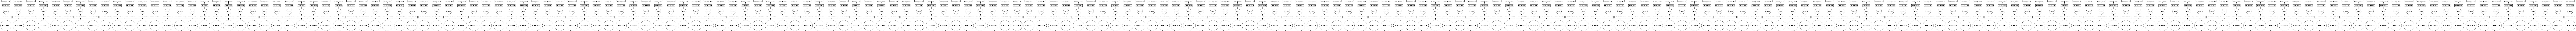

In [23]:
df._visualize()

Aha!<br>
Let's try another format

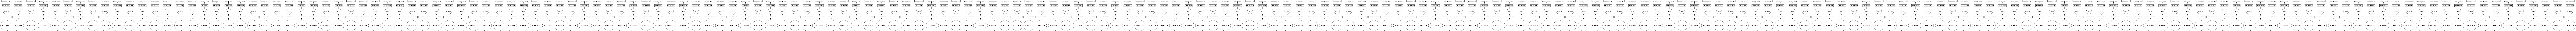

In [24]:
df._visualize(format='jpeg')

In [25]:
df._visualize(format='svg')

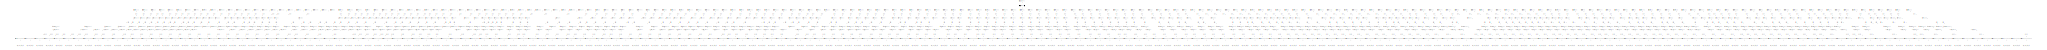

In [27]:
df.begin_zeit.max()._visualize(format='svg')

In [28]:
df.begin_zeit.max().compute()

C:\Users\admin\Anaconda3\lib\site-packages\pandas\computation\expressions.py:62: RuntimeWarning: invalid value encountered in remainder
  return op(a, b)


ValueError: Cannot convert NA to integer

Traceback
---------
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 263, in execute_task
    result = _execute_task(task, data)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 245, in _execute_task
    return func(*args2)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\compatibility.py", line 47, in apply
    return func(*args, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 49, in bytes_read_csv
    coerce_dtypes(df, dtypes)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 73, in coerce_dtypes
    df[c] = df[c].astype(dtypes[c])
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2950, in astype
    raise_on_error=raise_on_error, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2938, in astype
    return self.apply('astype', dtype=dtype, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2890, in apply
    applied = getattr(b, f)(**kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 434, in astype
    values=values, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 477, in _astype
    values = com._astype_nansafe(values.ravel(), dtype, copy=True)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\common.py", line 1914, in _astype_nansafe
    raise ValueError('Cannot convert NA to integer')


    ValueError: Cannot convert NA to integer

So let's drop all columns with only NaN!

In [29]:
neu = df.dropna(axis=1, how='all')

TypeError: dropna() got an unexpected keyword argument 'axis'

A look at the docs reveals:

Dask doesn’t supports following argument(s).

* axis
* thresh
* inplace

### F.....k. 
Okay, so how about dropping all NaN?

In [30]:
neu = df.dropna(how='all')
neu.compute()

C:\Users\admin\Anaconda3\lib\site-packages\pandas\computation\expressions.py:62: RuntimeWarning: invalid value encountered in remainder
  return op(a, b)


ValueError: Cannot convert NA to integer

Traceback
---------
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 263, in execute_task
    result = _execute_task(task, data)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 245, in _execute_task
    return func(*args2)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\compatibility.py", line 47, in apply
    return func(*args, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 49, in bytes_read_csv
    coerce_dtypes(df, dtypes)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 73, in coerce_dtypes
    df[c] = df[c].astype(dtypes[c])
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2950, in astype
    raise_on_error=raise_on_error, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2938, in astype
    return self.apply('astype', dtype=dtype, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2890, in apply
    applied = getattr(b, f)(**kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 434, in astype
    values=values, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 477, in _astype
    values = com._astype_nansafe(values.ravel(), dtype, copy=True)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\common.py", line 1914, in _astype_nansafe
    raise ValueError('Cannot convert NA to integer')


    ValueError: Cannot convert NA to integer
    
Find out, which columns contain only NaN in the first rows, use that to specify dtype in pd.read_csv

In [32]:
erste = pd.read_csv('a_ereignis.csv', delimiter=';', decimal=',', nrows=1000)
out = erste.columns[pd.isnull(erste).all()].tolist()

In [33]:
dic= dict.fromkeys(out, str)
dic

{'bearb': str,
 'bearb_date': str,
 'bearb_time': str,
 'herkunft': str,
 'lst_einh_01': str,
 'lst_einh_02': str,
 'lst_einh_03': str,
 'lst_einh_04': str,
 'lst_einh_05': str,
 'lst_einh_06': str,
 'lst_einh_07': str,
 'lst_einh_08': str,
 'lst_einh_09': str,
 'lst_einh_10': str,
 'mauftr': str,
 'schichtart': str,
 'user_c_29': str,
 'user_c_30': str,
 'user_c_31': str,
 'user_c_32': str,
 'user_c_33': str,
 'user_c_34': str,
 'user_c_35': str,
 'user_c_36': str,
 'user_c_37': str,
 'user_c_38': str,
 'user_c_39': str,
 'user_c_40': str,
 'user_c_41': str,
 'user_c_42': str,
 'user_c_43': str,
 'user_c_44': str,
 'user_c_45': str,
 'user_c_46': str,
 'user_c_47': str,
 'user_c_48': str,
 'user_c_49': str,
 'user_c_50': str,
 'user_c_51': str,
 'user_c_52': str,
 'user_c_53': str,
 'user_c_54': str,
 'user_c_55': str,
 'user_c_56': str,
 'user_c_57': str,
 'user_c_58': str,
 'user_c_59': str,
 'user_c_60': str,
 'user_c_61': str,
 'user_c_62': str,
 'user_c_63': str,
 'user_c_64': st

In [34]:
# manually add known mixed dtype columns
dic['\ufeffmasch_nr'] = str
dic['person_nr']= str

In [35]:
df = dd.read_csv('a_ereignis.csv', delimiter=';', dtype=dic, decimal=',', encoding='utf-8')
df.head()

﻿masch_nr  kostenstelle   verweis satzart  begin_zeit  \
0   1047013      21010400  13797356       P        6101   
1   1045800      21010400  13798881       P       14076   
2   1043201      21010400  13800013       P       18493   
3   2020210      31010010  13800624       N       82800   
4   1047005      21010400  13797359       P        6196   

                 begin_dat  ende_zeit  dauer     solltakt teiligkeit  \
0  2014-05-01 00:00:00.000       6205    104  1500.000000   1.000000   
1  2014-05-01 00:00:00.000      14172     96  1071.000000   1.000000   
2  2014-05-01 00:00:00.000      18890    397   500.000000   1.000000   
3  2014-04-30 00:00:00.000      21600  23400     0.000000   1.000000   
4  2014-05-01 00:00:00.000       6214     18  1500.000000   1.000000   

     ...      user_c_57  user_c_58  user_c_59  user_c_60  user_c_61  \
0    ...            NaN        NaN        NaN        NaN        NaN   
1    ...            NaN        NaN        NaN        NaN        NaN   
2    ...            NaN        NaN        NaN        NaN        NaN   
3    ...            NaN        NaN        NaN        NaN        NaN   
4    ...            NaN        NaN        NaN        NaN        NaN   

   user_c_62  user_c_63  user_c_64  user_c_65  user_c_66  
0        NaN        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN        NaN  
2        NaN        NaN        NaN        NaN        NaN  
3        NaN        NaN        NaN        NaN        NaN  
4        NaN        NaN        NaN        NaN        NaN  

[5 rows x 166 columns]

In [36]:
# trying a computation on a known dtype 'float' column
df.dauer.sum().compute()

C:\Users\admin\Anaconda3\lib\site-packages\pandas\computation\expressions.py:62: RuntimeWarning: invalid value encountered in remainder
  return op(a, b)


ValueError: Cannot convert NA to integer

Traceback
---------
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 263, in execute_task
    result = _execute_task(task, data)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 245, in _execute_task
    return func(*args2)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\compatibility.py", line 47, in apply
    return func(*args, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 49, in bytes_read_csv
    coerce_dtypes(df, dtypes)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 73, in coerce_dtypes
    df[c] = df[c].astype(dtypes[c])
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2950, in astype
    raise_on_error=raise_on_error, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2938, in astype
    return self.apply('astype', dtype=dtype, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2890, in apply
    applied = getattr(b, f)(**kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 434, in astype
    values=values, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 477, in _astype
    values = com._astype_nansafe(values.ravel(), dtype, copy=True)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\common.py", line 1914, in _astype_nansafe
    raise ValueError('Cannot convert NA to integer')


    ValueError: Cannot convert NA to integer
    
How about changing NaN's then?

In [37]:
df.fillna(value=0).compute()

C:\Users\admin\Anaconda3\lib\site-packages\pandas\computation\expressions.py:62: RuntimeWarning: invalid value encountered in remainder
  return op(a, b)


ValueError: Cannot convert NA to integer

Traceback
---------
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 263, in execute_task
    result = _execute_task(task, data)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\async.py", line 245, in _execute_task
    return func(*args2)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\compatibility.py", line 47, in apply
    return func(*args, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 49, in bytes_read_csv
    coerce_dtypes(df, dtypes)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dask\dataframe\csv.py", line 73, in coerce_dtypes
    df[c] = df[c].astype(dtypes[c])
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2950, in astype
    raise_on_error=raise_on_error, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2938, in astype
    return self.apply('astype', dtype=dtype, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 2890, in apply
    applied = getattr(b, f)(**kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 434, in astype
    values=values, **kwargs)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\internals.py", line 477, in _astype
    values = com._astype_nansafe(values.ravel(), dtype, copy=True)
  File "C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\common.py", line 1914, in _astype_nansafe
    raise ValueError('Cannot convert NA to integer')


### Yeah right...
    
    ValueError: Cannot convert NA to integer

Ultimate workaround (after hours of trying...): setting all cols to dtype object.   
This probably has all kinds of drawbacks, size of 'str' is larger.

In [ ]:
df = dd.read_csv('a_ereignis.csv', delimiter=';', dtype=object, decimal=',')
df.head()

In [ ]:
%time len(df)

    Wall time: 6min 38s
    Out[3]: 13782593

In [ ]:
df2 = df.set_index('kostenstelle')
df2.divisions

### The end...

* It's difficult to clean up messy, untidy data if it doesn't fit memory.
* There are probably lots of solutions for this, my approach with Dask/Pandas   
ultimatly yields an unwieldy file
* I ended up with script to reduce the size of 13 GB file to 1.3 GB --> Pandas

In [ ]:
chunksize = 20000
index_start = 1

for df in pd.read_csv('a_ereignis.csv', chunksize=chunksize, iterator=True, encoding='utf-8', delimiter=';'):
    
    df.index += index_start

    # Remove the un-interesting columns
    columns = ['\ufeffmasch_nr', 'kostenstelle', 'begin_zeit', 'begin_dat', 'schichtnr', 'ende_zeit', 'ende_dat', 'dauer',
               'stoertxt_nr', 'm_status', 'bmktonr']
    
    for c in df.columns:
        if c not in columns:
            df = df.drop(c, axis=1)    

    

    df.to_csv('arc_ereignis.csv', mode = 'a', header=False)
    index_start = df.index[-1] + 1

### Thank you!
###   
* Questions?
* Other projects: 
    * Python-scripts in Blender to generate 'walkable' 3d data visualisations for Virtual Reality
    * Virtual Reality and theatre: vtheater.net
* contact: lengers@wkd-werkstatt.de